In [1]:
from strategy.competition import Competition
from datetime import datetime, timedelta
import pytz
import pandas as pd
from tqdm import tqdm
from modeler.modeler import Modeler as m
from processor.processor import Processor as p
import numpy as np
import matplotlib.pyplot as plt

In [2]:
start_date = datetime(2016,1,1)
end_date = datetime(2021,1,1)
comp = Competition(start_date,end_date)

In [3]:
comp.subscribe()
initial_data = comp.initial_transform()
# sim = comp.create_sim()

In [11]:
comp.db.connect()
sim = comp.db.retrieve_sim(comp.modeling_params)
comp.db.disconnect()

In [12]:
sim

,date,ticker,adjclose,categories,skl_prediction,skl_score,xgb_prediction,xgb_score,cat_prediction,cat_score,prediction,score,delta,model_training_year,score_requirement,light_prediction,light_score
0,2016-01-04,MMM,123.956463,2,121.88495,0.716256,119.389885,0.951173,124.059791,0.946893,121.778208,0.871441,-0.017573,1,70,NaN,NaN
1,2016-01-05,MMM,124.496799,2,121.88495,0.716256,119.389885,0.951173,124.059791,0.946893,121.778208,0.871441,-0.021837,1,70,NaN,NaN
2,2016-01-06,MMM,121.989302,2,121.88495,0.716256,119.389885,0.951173,124.059791,0.946893,121.778208,0.871441,-0.001730,1,70,NaN,NaN
3,2016-01-07,MMM,119.017454,2,121.88495,0.716256,119.389885,0.951173,124.059791,0.946893,121.778208,0.871441,0.023196,1,70,NaN,NaN
4,2016-01-08,MMM,118.612202,2,121.88495,0.716256,119.389885,0.951173,124.059791,0.946893,121.778208,0.871441,0.026692,1,70,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
473559,2019-12-24,XYL,77.053457,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,70,NaN,NaN
473560,2019-12-26,XYL,77.014264,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,70,NaN,NaN
473561,2019-12-27,XYL,77.249422,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,70,NaN,NaN
473562,2020-01-02,XYL,78.239046,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,70,NaN,NaN


In [6]:
len(sim[sim["date"]>=datetime(2017,12,1)]["ticker"].unique())

484

In [13]:
start_year = comp.start_date.year
end_year = comp.end_date.year
categories_nums = comp.modeling_params["categories"]
model_training_year = comp.modeling_params["model_training_year"]
sims = []
market = comp.subscriptions["market"]["db"]
market.connect()
sp5 = market.retrieve("sp500")
comp.db.connect()
for year in tqdm(range(start_year,end_year),desc="competition_sim_year"):
    for quarter in tqdm(range(1,5),desc="competition_sim_quarter"):
        for ticker in tqdm(list(sp5["Symbol"].unique()),desc="competition_sim_ticker"):
            try:
                model_data = comp.db.retrieve_transformed(ticker)
                model_data.sort_values("date",ascending=True,inplace=True)
                model_data.reset_index(inplace=True,drop=True)
                first_index = model_data[(model_data["year"] == (year - model_training_year - 1)) & (model_data["quarter"]==quarter)].index.values.tolist()[0]
                last_index = model_data[(model_data["year"] == year) & (model_data["quarter"]==quarter)].index.values.tolist()[0]
                training_data = model_data.iloc[first_index:last_index].dropna().reset_index(drop=True)
                prediction_data = model_data[(model_data["year"] == year) & (model_data["quarter"]==quarter)].dropna().reset_index()
                factor_cols = [x for x in training_data.columns if x not in ["year","quarter","week","y","ticker","date"]]
                X = training_data[factor_cols]
                y = training_data["y"]
                models = m.regression({"X":X,"y":y})
                models["year"] = year
                models["quarter"] = quarter
                sim = prediction_data
                for i in range(models.index.size):
                    model = models.iloc[i]
                    api = model["api"]
                    score = model["score"]
                    if score >= comp.modeling_params["score_requirement"]/100:
                        sim[f"{api}_prediction"] = model["model"].predict(sim[factor_cols])
                        sim[f"{api}_score"] = model["score"].item()
                ticker_data = market.retrieve_ticker_prices("prices",ticker)
                prices = p.column_date_processing(ticker_data)
                prices["year"] = [x.year for x in prices["date"]]
                prices["week"] = [x.week for x in prices["date"]]
                sim = p.column_date_processing(sim)
                sim["year"] = [x.year for x in sim["date"]]
                sim["week"] = [x.week for x in sim["date"]]
                sim = prices[["date","year","week","ticker","adjclose"]].merge(sim.drop("date",axis=1),on=["year","week","ticker"],how="right").dropna()
                sim["categories"] = categories_nums
                final_cols = ["date","ticker","adjclose","categories"]
                final_cols.extend([x for x in list(sim.columns) if "prediction" in x or "score" in x])
                sim = sim[final_cols]
                sim.fillna(0,inplace=True)
                sim["prediction"] = [np.nanmean([row[1][x] for x in sim.columns if "prediction" in x and row[1][x] != 0]) for row in sim.iterrows()]
                sim["score"] = [np.nanmean([row[1][x] for x in sim.columns if "score" in x and row[1][x] != 0]) for row in sim.iterrows()]
                sim["delta"] = (sim["prediction"] - sim["adjclose"]) / sim["adjclose"]
                for param in comp.modeling_params:
                    sim[param]=comp.modeling_params[param]
                if sim.index.size > 1:
                    comp.db.store("sim",sim)
                    sims.append(sim)
            except Exception as e:
                print(ticker,str(e))
comp.db.disconnect()
market.disconnect()

competition_sim_quarter:   0%|                                                                                                            | 0/4 [00:00<?, ?it/s]

competition_sim_ticker:   0%|                                                                                                           | 0/505 [00:00<?, ?it/s]

competition_sim_ticker:   0%|▏                                                                                                | 1/505 [00:10<1:27:03, 10.36s/it]

competition_sim_ticker:   0%|▍                                                                                                | 2/505 [00:20<1:27:47, 10.47s/it]

competition_sim_ticker:   1%|▌                                                                                                | 3/505 [00:30<1:24:02, 10.05s/it]

competition_sim_ticker:   1%|▊                                                                                                | 4/505 [00:40<1:24:34, 10.13s/it]

competition_sim_ticker:   1%

BRK.B 'date'




competition_sim_ticker:  13%|████████████▊                                                                                     | 66/505 [10:21<57:59,  7.93s/it]

competition_sim_ticker:  13%|████████████▋                                                                                   | 67/505 [10:32<1:03:04,  8.64s/it]

competition_sim_ticker:  13%|████████████▉                                                                                   | 68/505 [10:41<1:05:21,  8.97s/it]

competition_sim_ticker:  14%|█████████████                                                                                   | 69/505 [10:52<1:07:54,  9.35s/it]

competition_sim_ticker:  14%|█████████████▎                                                                                  | 70/505 [11:02<1:10:38,  9.74s/it]

competition_sim_ticker:  14%|█████████████▍                                                                                  | 71/505 [11:13<1:13:09, 10.11s/it]

competition_sim_ticker:  1

BF.B 'date'




competition_sim_ticker:  16%|███████████████▏                                                                                | 80/505 [12:41<1:02:21,  8.80s/it]

competition_sim_ticker:  16%|███████████████▋                                                                                  | 81/505 [12:48<59:13,  8.38s/it]

competition_sim_ticker:  16%|███████████████▌                                                                                | 82/505 [12:59<1:04:57,  9.21s/it]

competition_sim_ticker:  16%|███████████████▊                                                                                | 83/505 [13:09<1:06:27,  9.45s/it]

competition_sim_ticker:  17%|███████████████▉                                                                                | 84/505 [13:19<1:07:38,  9.64s/it]

competition_sim_ticker:  17%|████████████████▏                                                                               | 85/505 [13:29<1:07:54,  9.70s/it]

competition_sim_ticker:  1

Found array with 0 sample(s) (shape=(0, 64)) while a minimum of 1 is required.
Cannot have number of splits n_splits=5 greater than the number of samples: n_samples=0.
Cannot have number of splits n_splits=5 greater than the number of samples: n_samples=0.
Cannot have number of splits n_splits=5 greater than the number of samples: n_samples=0.




competition_sim_ticker:  18%|█████████████████▍                                                                                | 90/505 [14:12<58:34,  8.47s/it]

competition_sim_ticker:  18%|█████████████████▎                                                                              | 91/505 [14:23<1:03:34,  9.21s/it]

competition_sim_ticker:  18%|█████████████████▍                                                                              | 92/505 [14:34<1:07:32,  9.81s/it]

competition_sim_ticker:  18%|█████████████████▋                                                                              | 93/505 [14:43<1:05:42,  9.57s/it]

competition_sim_ticker:  19%|█████████████████▊                                                                              | 94/505 [14:54<1:08:54, 10.06s/it]

competition_sim_ticker:  19%|██████████████████                                                                              | 95/505 [15:02<1:04:25,  9.43s/it]

competition_sim_ticker:  1

competition_sim_ticker:  37%|███████████████████████████████████▋                                                             | 186/505 [29:55<53:20, 10.03s/it]

competition_sim_ticker:  37%|███████████████████████████████████▉                                                             | 187/505 [30:04<51:17,  9.68s/it]

competition_sim_ticker:  37%|████████████████████████████████████                                                             | 188/505 [30:14<53:02, 10.04s/it]

competition_sim_ticker:  37%|████████████████████████████████████▎                                                            | 189/505 [30:23<51:13,  9.73s/it]

competition_sim_ticker:  38%|████████████████████████████████████▍                                                            | 190/505 [30:36<55:30, 10.57s/it]

competition_sim_ticker:  38%|████████████████████████████████████▋                                                            | 191/505 [30:47<56:23, 10.78s/it]

competition_sim_ticker:  38%

competition_sim_ticker:  56%|██████████████████████████████████████████████████████▏                                          | 282/505 [46:18<36:39,  9.86s/it]

competition_sim_ticker:  56%|██████████████████████████████████████████████████████▎                                          | 283/505 [46:29<37:31, 10.14s/it]

competition_sim_ticker:  56%|██████████████████████████████████████████████████████▌                                          | 284/505 [46:40<38:07, 10.35s/it]

competition_sim_ticker:  56%|██████████████████████████████████████████████████████▋                                          | 285/505 [46:51<38:21, 10.46s/it]

competition_sim_ticker:  57%|██████████████████████████████████████████████████████▉                                          | 286/505 [47:01<38:24, 10.52s/it]

competition_sim_ticker:  57%|███████████████████████████████████████████████████████▏                                         | 287/505 [47:14<40:08, 11.05s/it]

competition_sim_ticker:  57%

Found array with 0 sample(s) (shape=(0, 55)) while a minimum of 1 is required.
Cannot have number of splits n_splits=5 greater than the number of samples: n_samples=0.
Cannot have number of splits n_splits=5 greater than the number of samples: n_samples=0.
Cannot have number of splits n_splits=5 greater than the number of samples: n_samples=0.




competition_sim_ticker:  71%|████████████████████████████████████████████████████████████████████▊                            | 358/505 [58:12<11:50,  4.83s/it]

Found array with 0 sample(s) (shape=(0, 64)) while a minimum of 1 is required.
Cannot have number of splits n_splits=5 greater than the number of samples: n_samples=0.
Cannot have number of splits n_splits=5 greater than the number of samples: n_samples=0.
Cannot have number of splits n_splits=5 greater than the number of samples: n_samples=0.




competition_sim_ticker:  71%|████████████████████████████████████████████████████████████████████▉                            | 359/505 [58:22<16:07,  6.63s/it]

competition_sim_ticker:  71%|█████████████████████████████████████████████████████████████████████▏                           | 360/505 [58:30<16:59,  7.03s/it]

competition_sim_ticker:  71%|█████████████████████████████████████████████████████████████████████▎                           | 361/505 [58:41<19:06,  7.96s/it]

competition_sim_ticker:  72%|█████████████████████████████████████████████████████████████████████▌                           | 362/505 [58:51<20:30,  8.60s/it]

competition_sim_ticker:  72%|█████████████████████████████████████████████████████████████████████▋                           | 363/505 [59:02<22:19,  9.43s/it]

competition_sim_ticker:  72%|█████████████████████████████████████████████████████████████████████▉                           | 364/505 [59:13<23:08,  9.85s/it]

competition_sim_ticker:  7

competition_sim_ticker:  90%|█████████████████████████████████████████████████████████████████████████████████████▌         | 455/505 [1:14:42<07:43,  9.27s/it]

competition_sim_ticker:  90%|█████████████████████████████████████████████████████████████████████████████████████▊         | 456/505 [1:14:52<07:33,  9.25s/it]

competition_sim_ticker:  90%|█████████████████████████████████████████████████████████████████████████████████████▉         | 457/505 [1:15:01<07:26,  9.29s/it]

competition_sim_ticker:  91%|██████████████████████████████████████████████████████████████████████████████████████▏        | 458/505 [1:15:10<07:17,  9.31s/it]

competition_sim_ticker:  91%|██████████████████████████████████████████████████████████████████████████████████████▎        | 459/505 [1:15:21<07:29,  9.76s/it]

competition_sim_ticker:  91%|██████████████████████████████████████████████████████████████████████████████████████▌        | 460/505 [1:15:33<07:42, 10.28s/it]

competition_sim_ticker:  91%

Found array with 0 sample(s) (shape=(0, 55)) while a minimum of 1 is required.
Cannot have number of splits n_splits=5 greater than the number of samples: n_samples=0.
Cannot have number of splits n_splits=5 greater than the number of samples: n_samples=0.
Cannot have number of splits n_splits=5 greater than the number of samples: n_samples=0.




competition_sim_ticker:  94%|█████████████████████████████████████████████████████████████████████████████████████████▌     | 476/505 [1:18:11<03:59,  8.27s/it]

competition_sim_ticker:  94%|█████████████████████████████████████████████████████████████████████████████████████████▋     | 477/505 [1:18:19<03:52,  8.31s/it]

competition_sim_ticker:  95%|█████████████████████████████████████████████████████████████████████████████████████████▉     | 478/505 [1:18:28<03:49,  8.50s/it]

competition_sim_ticker:  95%|██████████████████████████████████████████████████████████████████████████████████████████     | 479/505 [1:18:40<04:10,  9.64s/it]

competition_sim_ticker:  95%|██████████████████████████████████████████████████████████████████████████████████████████▎    | 480/505 [1:18:52<04:13, 10.15s/it]

competition_sim_ticker:  95%|██████████████████████████████████████████████████████████████████████████████████████████▍    | 481/505 [1:19:01<03:56,  9.84s/it]

competition_sim_ticker:  9

Found array with 0 sample(s) (shape=(0, 56)) while a minimum of 1 is required.
Cannot have number of splits n_splits=5 greater than the number of samples: n_samples=0.
Cannot have number of splits n_splits=5 greater than the number of samples: n_samples=0.
Cannot have number of splits n_splits=5 greater than the number of samples: n_samples=0.




competition_sim_ticker:  99%|██████████████████████████████████████████████████████████████████████████████████████████████▍| 502/505 [1:22:10<00:15,  5.31s/it]

ZBRA 'date'




competition_sim_ticker: 100%|██████████████████████████████████████████████████████████████████████████████████████████████▌| 503/505 [1:22:10<00:07,  3.79s/it]

ZBH 'date'




competition_sim_ticker: 100%|██████████████████████████████████████████████████████████████████████████████████████████████▊| 504/505 [1:22:10<00:02,  2.73s/it]

ZION 'date'




competition_sim_ticker: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 505/505 [1:22:10<00:00,  9.76s/it]

competition_sim_quarter:  25%|███████████████████████▌                                                                      | 1/4 [1:22:10<4:06:32, 4930.98s/it]

ZTS 'date'




competition_sim_ticker:   0%|                                                                                                           | 0/505 [00:00<?, ?it/s]

competition_sim_ticker:   0%|▏                                                                                                | 1/505 [00:11<1:40:19, 11.94s/it]

competition_sim_ticker:   0%|▍                                                                                                | 2/505 [00:21<1:28:01, 10.50s/it]

competition_sim_ticker:   1%|▌                                                                                                | 3/505 [00:30<1:23:55, 10.03s/it]

competition_sim_ticker:   1%|▊                                                                                                | 4/505 [00:41<1:26:44, 10.39s/it]

competition_sim_ticker:   1%|▉                                                                                                | 5/505 [00:53<1:29:49, 10.78s/it]

competition_sim_ticker:   

BRK.B 'date'




competition_sim_ticker:  13%|████████████▊                                                                                     | 66/505 [10:49<59:10,  8.09s/it]

competition_sim_ticker:  13%|████████████▋                                                                                   | 67/505 [11:00<1:04:09,  8.79s/it]

competition_sim_ticker:  13%|████████████▉                                                                                   | 68/505 [11:10<1:06:23,  9.12s/it]

competition_sim_ticker:  14%|█████████████                                                                                   | 69/505 [11:20<1:09:08,  9.52s/it]

competition_sim_ticker:  14%|█████████████▎                                                                                  | 70/505 [11:30<1:09:06,  9.53s/it]

competition_sim_ticker:  14%|█████████████▍                                                                                  | 71/505 [11:43<1:16:27, 10.57s/it]

competition_sim_ticker:  1

BF.B 'date'




competition_sim_ticker:  16%|███████████████▏                                                                                | 80/505 [13:04<1:03:24,  8.95s/it]

competition_sim_ticker:  16%|███████████████▍                                                                                | 81/505 [13:12<1:01:37,  8.72s/it]

competition_sim_ticker:  16%|███████████████▌                                                                                | 82/505 [13:22<1:04:04,  9.09s/it]

competition_sim_ticker:  16%|███████████████▊                                                                                | 83/505 [13:33<1:06:42,  9.48s/it]

competition_sim_ticker:  17%|███████████████▉                                                                                | 84/505 [13:42<1:05:51,  9.39s/it]

competition_sim_ticker:  17%|████████████████▏                                                                               | 85/505 [13:53<1:08:47,  9.83s/it]

competition_sim_ticker:  1

Cannot have number of splits n_splits=5 greater than the number of samples: n_samples=3.
Cannot have number of splits n_splits=5 greater than the number of samples: n_samples=3.
Cannot have number of splits n_splits=5 greater than the number of samples: n_samples=3.




competition_sim_ticker:  18%|█████████████████▍                                                                                | 90/505 [14:34<55:47,  8.07s/it]

competition_sim_ticker:  18%|█████████████████▎                                                                              | 91/505 [14:46<1:04:44,  9.38s/it]

competition_sim_ticker:  18%|█████████████████▍                                                                              | 92/505 [14:56<1:04:56,  9.43s/it]

competition_sim_ticker:  18%|█████████████████▋                                                                              | 93/505 [15:04<1:02:24,  9.09s/it]

competition_sim_ticker:  19%|█████████████████▊                                                                              | 94/505 [15:16<1:08:38, 10.02s/it]

competition_sim_ticker:  19%|██████████████████                                                                              | 95/505 [15:25<1:04:36,  9.46s/it]

competition_sim_ticker:  1

competition_sim_ticker:  37%|███████████████████████████████████▋                                                             | 186/505 [30:33<54:26, 10.24s/it]

competition_sim_ticker:  37%|███████████████████████████████████▉                                                             | 187/505 [30:41<50:29,  9.53s/it]

competition_sim_ticker:  37%|████████████████████████████████████                                                             | 188/505 [30:53<53:20, 10.09s/it]

competition_sim_ticker:  37%|████████████████████████████████████▎                                                            | 189/505 [31:01<50:23,  9.57s/it]

competition_sim_ticker:  38%|████████████████████████████████████▍                                                            | 190/505 [31:14<55:21, 10.55s/it]

competition_sim_ticker:  38%|████████████████████████████████████▋                                                            | 191/505 [31:25<56:28, 10.79s/it]

competition_sim_ticker:  38%

competition_sim_ticker:  56%|██████████████████████████████████████████████████████▏                                          | 282/505 [47:32<39:33, 10.64s/it]

competition_sim_ticker:  56%|██████████████████████████████████████████████████████▎                                          | 283/505 [47:43<40:15, 10.88s/it]

competition_sim_ticker:  56%|██████████████████████████████████████████████████████▌                                          | 284/505 [47:55<40:57, 11.12s/it]

competition_sim_ticker:  56%|██████████████████████████████████████████████████████▋                                          | 285/505 [48:05<40:04, 10.93s/it]

competition_sim_ticker:  57%|██████████████████████████████████████████████████████▉                                          | 286/505 [48:16<39:21, 10.78s/it]

competition_sim_ticker:  57%|███████████████████████████████████████████████████████▏                                         | 287/505 [48:26<38:21, 10.56s/it]

competition_sim_ticker:  57%

Found array with 0 sample(s) (shape=(0, 55)) while a minimum of 1 is required.
Cannot have number of splits n_splits=5 greater than the number of samples: n_samples=0.
Cannot have number of splits n_splits=5 greater than the number of samples: n_samples=0.
Cannot have number of splits n_splits=5 greater than the number of samples: n_samples=0.




competition_sim_ticker:  71%|███████████████████████████████████████████████████████████████████▎                           | 358/505 [1:00:02<12:07,  4.95s/it]

Cannot have number of splits n_splits=5 greater than the number of samples: n_samples=3.
Cannot have number of splits n_splits=5 greater than the number of samples: n_samples=3.
Cannot have number of splits n_splits=5 greater than the number of samples: n_samples=3.




competition_sim_ticker:  71%|███████████████████████████████████████████████████████████████████▌                           | 359/505 [1:00:16<18:25,  7.57s/it]

competition_sim_ticker:  71%|███████████████████████████████████████████████████████████████████▋                           | 360/505 [1:00:24<18:47,  7.78s/it]

competition_sim_ticker:  71%|███████████████████████████████████████████████████████████████████▉                           | 361/505 [1:00:35<20:34,  8.57s/it]

competition_sim_ticker:  72%|████████████████████████████████████████████████████████████████████                           | 362/505 [1:00:47<22:50,  9.58s/it]

competition_sim_ticker:  72%|████████████████████████████████████████████████████████████████████▎                          | 363/505 [1:00:59<24:18, 10.27s/it]

competition_sim_ticker:  72%|████████████████████████████████████████████████████████████████████▍                          | 364/505 [1:01:10<25:12, 10.73s/it]

competition_sim_ticker:  7

competition_sim_ticker:  90%|█████████████████████████████████████████████████████████████████████████████████████▌         | 455/505 [1:17:35<08:51, 10.63s/it]

competition_sim_ticker:  90%|█████████████████████████████████████████████████████████████████████████████████████▊         | 456/505 [1:17:47<08:59, 11.01s/it]

competition_sim_ticker:  90%|█████████████████████████████████████████████████████████████████████████████████████▉         | 457/505 [1:17:57<08:37, 10.78s/it]

competition_sim_ticker:  91%|██████████████████████████████████████████████████████████████████████████████████████▏        | 458/505 [1:18:08<08:22, 10.69s/it]

competition_sim_ticker:  91%|██████████████████████████████████████████████████████████████████████████████████████▎        | 459/505 [1:18:19<08:18, 10.83s/it]

competition_sim_ticker:  91%|██████████████████████████████████████████████████████████████████████████████████████▌        | 460/505 [1:18:30<08:10, 10.91s/it]

competition_sim_ticker:  91%

Found array with 0 sample(s) (shape=(0, 55)) while a minimum of 1 is required.
Cannot have number of splits n_splits=5 greater than the number of samples: n_samples=0.
Cannot have number of splits n_splits=5 greater than the number of samples: n_samples=0.
Cannot have number of splits n_splits=5 greater than the number of samples: n_samples=0.




competition_sim_ticker:  94%|█████████████████████████████████████████████████████████████████████████████████████████▌     | 476/505 [1:21:13<03:56,  8.14s/it]

competition_sim_ticker:  94%|█████████████████████████████████████████████████████████████████████████████████████████▋     | 477/505 [1:21:22<04:02,  8.66s/it]

competition_sim_ticker:  95%|█████████████████████████████████████████████████████████████████████████████████████████▉     | 478/505 [1:21:31<03:54,  8.70s/it]

competition_sim_ticker:  95%|██████████████████████████████████████████████████████████████████████████████████████████     | 479/505 [1:21:42<04:01,  9.29s/it]

competition_sim_ticker:  95%|██████████████████████████████████████████████████████████████████████████████████████████▎    | 480/505 [1:21:55<04:18, 10.35s/it]

competition_sim_ticker:  95%|██████████████████████████████████████████████████████████████████████████████████████████▍    | 481/505 [1:22:04<03:58,  9.92s/it]

competition_sim_ticker:  9

Found array with 0 sample(s) (shape=(0, 56)) while a minimum of 1 is required.
Cannot have number of splits n_splits=5 greater than the number of samples: n_samples=0.
Cannot have number of splits n_splits=5 greater than the number of samples: n_samples=0.
Cannot have number of splits n_splits=5 greater than the number of samples: n_samples=0.




competition_sim_ticker:  99%|██████████████████████████████████████████████████████████████████████████████████████████████▍| 502/505 [1:25:23<00:16,  5.63s/it]

ZBRA 'date'




competition_sim_ticker: 100%|██████████████████████████████████████████████████████████████████████████████████████████████▌| 503/505 [1:25:23<00:08,  4.02s/it]

ZBH 'date'




competition_sim_ticker: 100%|██████████████████████████████████████████████████████████████████████████████████████████████▊| 504/505 [1:25:23<00:02,  2.89s/it]

ZION 'date'




competition_sim_ticker: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 505/505 [1:25:24<00:00, 10.15s/it]

competition_sim_quarter:  50%|███████████████████████████████████████████████                                               | 2/4 [2:47:35<2:48:09, 5044.66s/it]

ZTS 'date'




competition_sim_ticker:   0%|                                                                                                           | 0/505 [00:00<?, ?it/s]

competition_sim_ticker:   0%|▏                                                                                                | 1/505 [00:13<1:51:34, 13.28s/it]

competition_sim_ticker:   0%|▍                                                                                                | 2/505 [00:24<1:42:27, 12.22s/it]

competition_sim_ticker:   1%|▌                                                                                                | 3/505 [00:36<1:38:56, 11.82s/it]

competition_sim_ticker:   1%|▊                                                                                                | 4/505 [00:46<1:34:41, 11.34s/it]

competition_sim_ticker:   1%|▉                                                                                                | 5/505 [00:58<1:34:55, 11.39s/it]

competition_sim_ticker:   

BRK.B 'date'




competition_sim_ticker:  13%|████████████▌                                                                                   | 66/505 [11:59<1:06:26,  9.08s/it]

competition_sim_ticker:  13%|████████████▋                                                                                   | 67/505 [12:10<1:10:28,  9.65s/it]

competition_sim_ticker:  13%|████████████▉                                                                                   | 68/505 [12:22<1:15:57, 10.43s/it]

competition_sim_ticker:  14%|█████████████                                                                                   | 69/505 [12:33<1:17:29, 10.66s/it]

competition_sim_ticker:  14%|█████████████▎                                                                                  | 70/505 [12:46<1:20:48, 11.15s/it]

competition_sim_ticker:  14%|█████████████▍                                                                                  | 71/505 [12:59<1:26:26, 11.95s/it]

competition_sim_ticker:  1

BF.B 'date'




competition_sim_ticker:  16%|███████████████▏                                                                                | 80/505 [14:33<1:10:57, 10.02s/it]

competition_sim_ticker:  16%|███████████████▍                                                                                | 81/505 [14:42<1:09:06,  9.78s/it]

competition_sim_ticker:  16%|███████████████▌                                                                                | 82/505 [14:55<1:14:35, 10.58s/it]

competition_sim_ticker:  16%|███████████████▊                                                                                | 83/505 [15:06<1:15:25, 10.73s/it]

competition_sim_ticker:  17%|███████████████▉                                                                                | 84/505 [15:15<1:11:49, 10.24s/it]

competition_sim_ticker:  17%|████████████████▏                                                                               | 85/505 [15:26<1:12:52, 10.41s/it]

competition_sim_ticker:  1

competition_sim_ticker:  35%|█████████████████████████████████▊                                                               | 176/505 [31:49<53:54,  9.83s/it]

competition_sim_ticker:  35%|█████████████████████████████████▉                                                               | 177/505 [32:02<58:44, 10.74s/it]

competition_sim_ticker:  35%|██████████████████████████████████▏                                                              | 178/505 [32:11<55:21, 10.16s/it]

competition_sim_ticker:  35%|██████████████████████████████████▍                                                              | 179/505 [32:19<52:50,  9.73s/it]

competition_sim_ticker:  36%|██████████████████████████████████▌                                                              | 180/505 [32:30<54:23, 10.04s/it]

competition_sim_ticker:  36%|██████████████████████████████████▊                                                              | 181/505 [32:39<52:55,  9.80s/it]

competition_sim_ticker:  36%

competition_sim_ticker:  54%|████████████████████████████████████████████████████▏                                            | 272/505 [50:11<43:09, 11.11s/it]

competition_sim_ticker:  54%|████████████████████████████████████████████████████▍                                            | 273/505 [50:21<41:42, 10.79s/it]

competition_sim_ticker:  54%|████████████████████████████████████████████████████▋                                            | 274/505 [50:30<39:48, 10.34s/it]

competition_sim_ticker:  54%|████████████████████████████████████████████████████▊                                            | 275/505 [50:43<42:24, 11.06s/it]

competition_sim_ticker:  55%|█████████████████████████████████████████████████████                                            | 276/505 [50:53<41:12, 10.80s/it]

competition_sim_ticker:  55%|█████████████████████████████████████████████████████▏                                           | 277/505 [51:04<40:34, 10.68s/it]

competition_sim_ticker:  55%

Found array with 0 sample(s) (shape=(0, 55)) while a minimum of 1 is required.
Cannot have number of splits n_splits=5 greater than the number of samples: n_samples=0.
Cannot have number of splits n_splits=5 greater than the number of samples: n_samples=0.
Cannot have number of splits n_splits=5 greater than the number of samples: n_samples=0.




competition_sim_ticker:  71%|███████████████████████████████████████████████████████████████████▎                           | 358/505 [1:06:14<19:24,  7.92s/it]

competition_sim_ticker:  71%|███████████████████████████████████████████████████████████████████▌                           | 359/505 [1:06:26<22:36,  9.29s/it]

competition_sim_ticker:  71%|███████████████████████████████████████████████████████████████████▋                           | 360/505 [1:06:35<22:10,  9.17s/it]

competition_sim_ticker:  71%|███████████████████████████████████████████████████████████████████▉                           | 361/505 [1:06:48<24:48, 10.34s/it]

competition_sim_ticker:  72%|████████████████████████████████████████████████████████████████████                           | 362/505 [1:07:00<25:41, 10.78s/it]

competition_sim_ticker:  72%|████████████████████████████████████████████████████████████████████▎                          | 363/505 [1:07:12<26:12, 11.07s/it]

competition_sim_ticker:  7

competition_sim_ticker:  90%|█████████████████████████████████████████████████████████████████████████████████████▍         | 454/505 [1:25:06<09:55, 11.67s/it]

competition_sim_ticker:  90%|█████████████████████████████████████████████████████████████████████████████████████▌         | 455/505 [1:25:17<09:26, 11.33s/it]

competition_sim_ticker:  90%|█████████████████████████████████████████████████████████████████████████████████████▊         | 456/505 [1:25:29<09:27, 11.58s/it]

competition_sim_ticker:  90%|█████████████████████████████████████████████████████████████████████████████████████▉         | 457/505 [1:25:42<09:38, 12.06s/it]

competition_sim_ticker:  91%|██████████████████████████████████████████████████████████████████████████████████████▏        | 458/505 [1:25:53<09:17, 11.86s/it]

competition_sim_ticker:  91%|██████████████████████████████████████████████████████████████████████████████████████▎        | 459/505 [1:26:06<09:14, 12.05s/it]

competition_sim_ticker:  91%

Found array with 0 sample(s) (shape=(0, 55)) while a minimum of 1 is required.
Cannot have number of splits n_splits=5 greater than the number of samples: n_samples=0.
Cannot have number of splits n_splits=5 greater than the number of samples: n_samples=0.
Cannot have number of splits n_splits=5 greater than the number of samples: n_samples=0.




competition_sim_ticker:  94%|█████████████████████████████████████████████████████████████████████████████████████████▌     | 476/505 [1:29:27<04:56, 10.24s/it]

competition_sim_ticker:  94%|█████████████████████████████████████████████████████████████████████████████████████████▋     | 477/505 [1:29:37<04:42, 10.09s/it]

competition_sim_ticker:  95%|█████████████████████████████████████████████████████████████████████████████████████████▉     | 478/505 [1:29:47<04:26,  9.88s/it]

competition_sim_ticker:  95%|██████████████████████████████████████████████████████████████████████████████████████████     | 479/505 [1:29:59<04:39, 10.77s/it]

competition_sim_ticker:  95%|██████████████████████████████████████████████████████████████████████████████████████████▎    | 480/505 [1:30:15<05:03, 12.14s/it]

competition_sim_ticker:  95%|██████████████████████████████████████████████████████████████████████████████████████████▍    | 481/505 [1:30:24<04:34, 11.43s/it]

competition_sim_ticker:  9

Found array with 0 sample(s) (shape=(0, 56)) while a minimum of 1 is required.
Cannot have number of splits n_splits=5 greater than the number of samples: n_samples=0.
Cannot have number of splits n_splits=5 greater than the number of samples: n_samples=0.
Cannot have number of splits n_splits=5 greater than the number of samples: n_samples=0.




competition_sim_ticker:  99%|██████████████████████████████████████████████████████████████████████████████████████████████▍| 502/505 [1:34:06<00:17,  5.90s/it]

ZBRA 'date'




competition_sim_ticker: 100%|██████████████████████████████████████████████████████████████████████████████████████████████▌| 503/505 [1:34:07<00:08,  4.20s/it]

ZBH 'date'




competition_sim_ticker: 100%|██████████████████████████████████████████████████████████████████████████████████████████████▊| 504/505 [1:34:07<00:03,  3.02s/it]

ZION 'date'




competition_sim_ticker: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 505/505 [1:34:07<00:00, 11.18s/it]

competition_sim_quarter:  75%|██████████████████████████████████████████████████████████████████████▌                       | 3/4 [4:21:42<1:28:40, 5320.03s/it]

ZTS 'date'




competition_sim_ticker:   0%|                                                                                                           | 0/505 [00:00<?, ?it/s]

competition_sim_ticker:   0%|▏                                                                                                | 1/505 [00:13<1:53:15, 13.48s/it]

competition_sim_ticker:   0%|▍                                                                                                | 2/505 [00:27<1:56:49, 13.94s/it]

competition_sim_ticker:   1%|▌                                                                                                | 3/505 [00:40<1:50:44, 13.24s/it]

competition_sim_ticker:   1%|▊                                                                                                | 4/505 [00:54<1:55:10, 13.79s/it]

competition_sim_ticker:   1%|▉                                                                                                | 5/505 [01:10<1:59:15, 14.31s/it]

competition_sim_ticker:   

BRK.B 'date'




competition_sim_ticker:  13%|████████████▌                                                                                   | 66/505 [14:11<1:18:32, 10.73s/it]

competition_sim_ticker:  13%|████████████▋                                                                                   | 67/505 [14:27<1:29:26, 12.25s/it]

competition_sim_ticker:  13%|████████████▉                                                                                   | 68/505 [14:42<1:35:24, 13.10s/it]

competition_sim_ticker:  14%|█████████████                                                                                   | 69/505 [14:57<1:39:23, 13.68s/it]

competition_sim_ticker:  14%|█████████████▎                                                                                  | 70/505 [15:10<1:37:33, 13.46s/it]

competition_sim_ticker:  14%|█████████████▍                                                                                  | 71/505 [15:26<1:41:41, 14.06s/it]

competition_sim_ticker:  1

BF.B 'date'




competition_sim_ticker:  16%|███████████████▏                                                                                | 80/505 [17:21<1:21:31, 11.51s/it]

competition_sim_ticker:  16%|███████████████▍                                                                                | 81/505 [17:30<1:16:05, 10.77s/it]

competition_sim_ticker:  16%|███████████████▌                                                                                | 82/505 [17:44<1:23:40, 11.87s/it]

competition_sim_ticker:  16%|███████████████▊                                                                                | 83/505 [17:59<1:28:44, 12.62s/it]

competition_sim_ticker:  17%|███████████████▉                                                                                | 84/505 [18:11<1:27:12, 12.43s/it]

competition_sim_ticker:  17%|████████████████▏                                                                               | 85/505 [18:23<1:28:04, 12.58s/it]

competition_sim_ticker:  1

competition_sim_ticker:  35%|█████████████████████████████████                                                              | 176/505 [38:12<1:03:59, 11.67s/it]

competition_sim_ticker:  35%|█████████████████████████████████▎                                                             | 177/505 [38:25<1:05:43, 12.02s/it]

competition_sim_ticker:  35%|█████████████████████████████████▍                                                             | 178/505 [38:34<1:01:48, 11.34s/it]

competition_sim_ticker:  35%|█████████████████████████████████▋                                                             | 179/505 [38:46<1:01:40, 11.35s/it]

competition_sim_ticker:  36%|█████████████████████████████████▊                                                             | 180/505 [39:00<1:05:54, 12.17s/it]

competition_sim_ticker:  36%|██████████████████████████████████                                                             | 181/505 [39:11<1:04:24, 11.93s/it]

competition_sim_ticker:  36%

competition_sim_ticker:  54%|███████████████████████████████████████████████████▏                                           | 272/505 [1:00:14<51:41, 13.31s/it]

competition_sim_ticker:  54%|███████████████████████████████████████████████████▎                                           | 273/505 [1:00:24<48:12, 12.47s/it]

competition_sim_ticker:  54%|███████████████████████████████████████████████████▌                                           | 274/505 [1:00:33<44:03, 11.44s/it]

competition_sim_ticker:  54%|███████████████████████████████████████████████████▋                                           | 275/505 [1:00:48<47:27, 12.38s/it]

competition_sim_ticker:  55%|███████████████████████████████████████████████████▉                                           | 276/505 [1:00:58<45:02, 11.80s/it]

competition_sim_ticker:  55%|████████████████████████████████████████████████████                                           | 277/505 [1:01:09<44:05, 11.60s/it]

competition_sim_ticker:  55%

Found array with 0 sample(s) (shape=(0, 55)) while a minimum of 1 is required.
Cannot have number of splits n_splits=5 greater than the number of samples: n_samples=0.
Cannot have number of splits n_splits=5 greater than the number of samples: n_samples=0.
Cannot have number of splits n_splits=5 greater than the number of samples: n_samples=0.




competition_sim_ticker:  71%|███████████████████████████████████████████████████████████████████▎                           | 358/505 [1:18:55<23:07,  9.44s/it]

competition_sim_ticker:  71%|███████████████████████████████████████████████████████████████████▌                           | 359/505 [1:19:10<26:49, 11.02s/it]

competition_sim_ticker:  71%|███████████████████████████████████████████████████████████████████▋                           | 360/505 [1:19:22<27:53, 11.54s/it]

competition_sim_ticker:  71%|███████████████████████████████████████████████████████████████████▉                           | 361/505 [1:19:39<31:28, 13.12s/it]

competition_sim_ticker:  72%|████████████████████████████████████████████████████████████████████                           | 362/505 [1:19:54<32:09, 13.49s/it]

competition_sim_ticker:  72%|████████████████████████████████████████████████████████████████████▎                          | 363/505 [1:20:07<31:53, 13.47s/it]

competition_sim_ticker:  7

competition_sim_ticker:  90%|█████████████████████████████████████████████████████████████████████████████████████▍         | 454/505 [1:41:34<11:35, 13.63s/it]

competition_sim_ticker:  90%|█████████████████████████████████████████████████████████████████████████████████████▌         | 455/505 [1:41:46<10:55, 13.11s/it]

competition_sim_ticker:  90%|█████████████████████████████████████████████████████████████████████████████████████▊         | 456/505 [1:42:01<11:14, 13.76s/it]

competition_sim_ticker:  90%|█████████████████████████████████████████████████████████████████████████████████████▉         | 457/505 [1:42:15<10:55, 13.66s/it]

competition_sim_ticker:  91%|██████████████████████████████████████████████████████████████████████████████████████▏        | 458/505 [1:42:32<11:35, 14.79s/it]

competition_sim_ticker:  91%|██████████████████████████████████████████████████████████████████████████████████████▎        | 459/505 [1:42:46<11:05, 14.47s/it]

competition_sim_ticker:  91%

Found array with 0 sample(s) (shape=(0, 55)) while a minimum of 1 is required.
Cannot have number of splits n_splits=5 greater than the number of samples: n_samples=0.
Cannot have number of splits n_splits=5 greater than the number of samples: n_samples=0.
Cannot have number of splits n_splits=5 greater than the number of samples: n_samples=0.




competition_sim_ticker:  94%|█████████████████████████████████████████████████████████████████████████████████████████▌     | 476/505 [1:46:22<05:28, 11.32s/it]

competition_sim_ticker:  94%|█████████████████████████████████████████████████████████████████████████████████████████▋     | 477/505 [1:46:34<05:21, 11.49s/it]

competition_sim_ticker:  95%|█████████████████████████████████████████████████████████████████████████████████████████▉     | 478/505 [1:46:44<05:04, 11.27s/it]

competition_sim_ticker:  95%|██████████████████████████████████████████████████████████████████████████████████████████     | 479/505 [1:47:00<05:26, 12.55s/it]

competition_sim_ticker:  95%|██████████████████████████████████████████████████████████████████████████████████████████▎    | 480/505 [1:47:15<05:29, 13.17s/it]

competition_sim_ticker:  95%|██████████████████████████████████████████████████████████████████████████████████████████▍    | 481/505 [1:47:26<05:00, 12.51s/it]

competition_sim_ticker:  9

Found array with 0 sample(s) (shape=(0, 56)) while a minimum of 1 is required.
Cannot have number of splits n_splits=5 greater than the number of samples: n_samples=0.
Cannot have number of splits n_splits=5 greater than the number of samples: n_samples=0.
Cannot have number of splits n_splits=5 greater than the number of samples: n_samples=0.




competition_sim_ticker:  99%|██████████████████████████████████████████████████████████████████████████████████████████████▍| 502/505 [1:51:55<00:22,  7.40s/it]

ZBRA 'date'




competition_sim_ticker: 100%|██████████████████████████████████████████████████████████████████████████████████████████████▌| 503/505 [1:51:56<00:10,  5.26s/it]

ZBH 'date'




competition_sim_ticker: 100%|██████████████████████████████████████████████████████████████████████████████████████████████▊| 504/505 [1:51:56<00:03,  3.75s/it]

ZION 'date'




competition_sim_ticker: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 505/505 [1:51:56<00:00, 13.30s/it]

competition_sim_year: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [6:13:39<00:00, 22419.62s/it]

ZTS 'date'


In [10]:
sim.head(2)

,date,ticker,adjclose,categories,prediction,score,delta,model_training_year,score_requirement


In [22]:
models

,api,model,score,model_type,year,quarter
0,skl,LinearRegression(),0.015167,regression,2016,1
1,xgb,"XGBRegressor(base_score=0.5, booster='dart', c...",-49.957633,regression,2016,1
2,light,"LGBMRegressor(boosting_type='dart', early_stop...",-64.282746,regression,2016,1
3,cat,<catboost.core.CatBoostRegressor object at 0x0...,-50.082306,regression,2016,1


In [23]:
analysis = sim

In [24]:
analysis.head(2)

,date,ticker,adjclose,categories,prediction,score,delta,model_training_year,score_requirement
0,2016-01-04,CRM,76.71,2,NaN,NaN,NaN,1,70
1,2016-01-05,CRM,77.05,2,NaN,NaN,NaN,1,70


In [25]:
analysis["year"] = [x.year for x in analysis["date"]]
analysis["week"] = [x.quarter for x in analysis["date"]]
# analysis["date"] = [datetime.strptime(f'{row[1]["year"]} {row[1]["week"]} 0', "%Y %W %w") for row in analysis.iterrows()]

In [28]:
analysis.dropna()

,date,ticker,adjclose,categories,prediction,score,delta,model_training_year,score_requirement,year,week


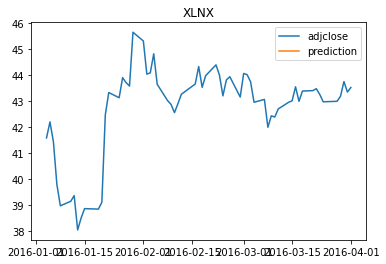

In [27]:
ticker_example = analysis[analysis["ticker"]==ticker].sort_values("date")
plt.plot(ticker_example["date"],ticker_example["adjclose"])
for col in [x for x in analysis.columns if "prediction" in x]:
    plt.plot(ticker_example["date"],ticker_example[col])
legend = ["adjclose"]
legend.extend([x for x in analysis.columns if "prediction" in x])
plt.legend(legend)
plt.title(ticker)
plt.show()